In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ginga.util import iqcalc
from scipy.interpolate import interp1d
from matplotlib.ticker import NullFormatter

In [2]:
# import LAM library for logbook, data analysis...
from pfs.sacFileHandling import stackedImage, Logbook, constructFilelist, getDateObs
from pfs.imageAnalysis import fitparabola, getEE, fitgauss1D

In [3]:
imgPath = '/home/pfs/shared/Pictures/SM1/SLITALIGN'

In [4]:
smId = 1

In [5]:
# filepath of data model
pmodel = '/home/pfs/dev/ait-notebook/optical/input/slit'
file = 'slit-defParam-Ouverture100-fiber65.csv'

In [6]:
zemaxData = pd.read_csv('%s/%s' % (pmodel, file), delimiter=" ")
zemaxMidFit = fitparabola(x=zemaxData.Slitdefocus, y=zemaxData.MidFiber, deg=15, focus='max')
zemaxEndFit = fitparabola(x=zemaxData.Slitdefocus, y=zemaxData.ExtremeFiber, deg=15, focus='max')

In [7]:
def getFiberPeak(filelist, ind, duplicate, doMeanBck, crit, radius=60, threshold=1000):
    calc = iqcalc.IQCalc(None)
    hdr, data = stackedImage(filelist=filelist, ind=ind, duplicate=duplicate, doMeanBck=doMeanBck)
    fca_x = hdr['FCA_X']

    peaks = calc.find_bright_peaks(data, threshold=threshold, radius=radius)

    objlist = calc.evaluate_peaks(peaks, data, fwhm_radius=radius, cb_fn=None, ev_intr=None, fwhm_method='gaussian')
    objlist = [elem for elem in objlist if elem['fwhm'] > 15]
    objlist = [elem for elem in objlist if 1000 < elem['brightness'] < 50000]
    if not objlist:
        raise ValueError('peak has not been properly detected')

    for peak in objlist:
        peak['fca_x'] = fca_x
        peak['EE'] = getEE(image=data, cx=peak['objx'], cy=peak['objy'], inner_size=20, outer_size=150)
        peak['flux_EE'] = np.sum(data)
        # center of mass
        peak['com_EE'] = getEE(image=data, cx=peak['oid_x'], cy=peak['oid_y'], inner_size=20, outer_size=150)

    maxi = np.argmax([obj[crit] for obj in objlist])
    
    return objlist[maxi]


def getDescription(experimentId):
    visitStart, visitEnd = Logbook.visitRange(experimentId=experimentId)
    filelist = constructFilelist(visitStart=visitStart, visitEnd=visitEnd)
    fibername = Logbook.getParameter(experimentId=experimentId, param='fiber', doRaise=False)  
    duplicate = int(Logbook.getParameter(experimentId=experimentId, param='duplicate'))
    dateobs = getDateObs(experimentId=experimentId)

    description = pd.DataFrame([(experimentId, dateobs, len(filelist), visitStart, visitEnd, fibername, duplicate)],
                               columns=['experimentId', 'dateobs', 'nbImages', 'visitStart', 'visitEnd', 'fiber',
                                        'duplicate'])

    return description


def getFiberTF(experimentId, doMeanBck, centerOfMass):
    visitStart, visitEnd = Logbook.visitRange(experimentId=experimentId)
    filelist = constructFilelist(visitStart=visitStart, visitEnd=visitEnd)
    duplicate = int(Logbook.getParameter(experimentId=experimentId, param='duplicate'))

    crit = 'com_EE' if centerOfMass else 'EE'
    res = []

    for i in range(len(filelist) // duplicate):
        try:
            fiberPeak = getFiberPeak(filelist, ind=i, duplicate=duplicate,
                                     doMeanBck=doMeanBck,
                                     crit=crit)
            res.append((experimentId,) + tuple(list(fiberPeak.values())))

        except ValueError:
            pass

    return pd.DataFrame(res, columns=['experimentId'] + list(fiberPeak.keys()))

In [8]:
experiments = pd.read_sql_query('select * from Experiment where experimentId>89 order by experimentId desc',
                                con='sqlite:////data/ait/ait-alignment.db', index_col='experimentId')

experiments['exptime'] = [Logbook.getParameter(experimentId, 'exptime') for experimentId in experiments.index]
experiments['fiber'] = [Logbook.getParameter(experimentId, 'fiber', doRaise=False) for experimentId in experiments.index]
experiments['dateobs'] = [getDateObs(experimentId=experimentId) for experimentId in experiments.index]

experiments

,name,visitStart,visitEnd,type,cmdStr,comments,anomalies,exptime,fiber,dateobs
experimentId,,,,,,,,,,
127,SM1 Focus Check,5451,5470,Slit_Alignment,slit throughfocus exptime=20 lowBound=-1 upBou...,eng bot mid+halogen,,20,,2018-11-07T14:13:24
126,SM1 Focus Check,5428,5447,Slit_Alignment,slit throughfocus exptime=20 lowBound=-1 upBou...,engfiber+halogen,,20,,2018-11-07T11:49:22
125,SM1 Focus Check,5377,5416,Slit_Alignment,slit throughfocus exptime=10.0 lowBound=-3 upB...,sac fully realign + neon fiber science bundle,,10.0,,2018-10-26T15:41:20
124,SM1 Focus Check,5371,5376,Slit_Alignment,slit throughfocus exptime=10.0 lowBound=-5 upB...,sac fully realign + neon fiber science bundle,,10.0,,2018-10-26T15:36:11
123,SM1 Focus Check,5359,5364,Slit_Alignment,slit throughfocus exptime=60.0 lowBound=-5 upB...,sac realign + halogen fiber source,,60.0,,2018-10-26T14:20:24
122,SM1 Focus Check,5264,5343,Slit_Alignment,slit throughfocus exptime=60.0 lowBound=-5 upB...,with SAC and Neon direct through dcb collimator,,60.0,,2018-10-24T16:35:09
121,SM1 Focus Check,5244,5263,Slit_Alignment,slit throughfocus exptime=60.0 lowBound=-5 upB...,with SAC and Neon direct through dcb collimator,,60.0,,2018-10-24T15:53:02
120,SM1 Focus Check,5195,5234,Slit_Alignment,slit throughfocus exptime=800.0 lowBound=-3 up...,with SAC and autocoll as source 670nm,,800.0,,2018-10-23T16:57:13
119,test pour Arnaud,5188,5191,Slit_Alignment,slit throughfocus exptime=2.0 lowBound=-2 upBo...,,,2.0,,2018-10-23T16:04:38


## Data required : 
To be able to find the right focus, some data acquisition is required.

you need to use ics_spsaitActor to perform your sequence

example : <b>slit throughfocus exptime=6.0 lowBound=-0.5 upBound=1.5 fiber=engbotend nbPosition=10 duplicate=1 </b>

-0.5 : 1.5 is the range of the slit focus


## Input Parameters : 
The only parameters needed is the experimentIds that match your data acquisition sequence

In [53]:
centerOfMass = True
doMeanBck = True
corrector=True
experimentIds = [126,127]  # the first experimentId is 12
dfs = []

In [54]:
crit = 'com_EE' if centerOfMass else 'EE'

for experimentId in experimentIds:
    dfs.append(getFiberTF(experimentId=experimentId, doMeanBck=doMeanBck, centerOfMass=centerOfMass))

cube = pd.concat(dfs)

/software/conda/lib/python3.6/site-packages/scipy/optimize/minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 800.
  warnings.warn(errors[info][0], RuntimeWarning)


In [55]:
descriptions = pd.concat([getDescription(experimentId) for experimentId, df in cube.groupby('experimentId')])
descriptions = descriptions.set_index('experimentId')
descriptions

,dateobs,nbImages,visitStart,visitEnd,fiber,duplicate
experimentId,,,,,,
126,2018-11-07T11:49:22,20,5428,5447,,1
127,2018-11-07T14:13:24,20,5451,5470,,1


In [56]:
lneg = 0
lpos = -1
vline = False

/home/pfs/dev/lib/pfs/imageAnalysis.py:44: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  popt1, pcov = curve_fit(oneD_Gaussian, x, y, p0=[np.max(y), x[y.argmax()], sig0, offset], maxfev=10000)


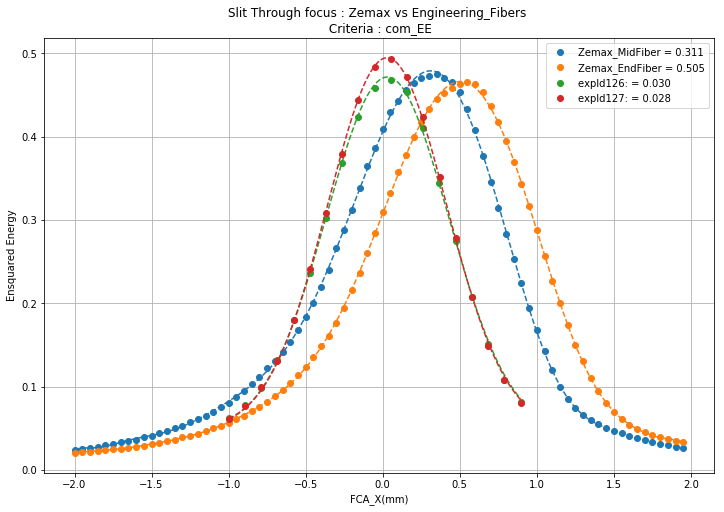

In [58]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(111)

ax1.plot(zemaxData.Slitdefocus, zemaxData.MidFiber, 'o', label='Zemax_MidFiber = %.3f' % zemaxMidFit.focus)
ax1.plot(zemaxMidFit.x, zemaxMidFit.y, '--', color=ax1.get_lines()[-1].get_color())
if vline:
    ax1.vlines(color=ax1.get_lines()[-1].get_color(), **zemaxMidFit.vline)

ax1.plot(zemaxData.Slitdefocus, zemaxData.ExtremeFiber, 'o', label='Zemax_EndFiber = %.3f' % zemaxEndFit.focus)
ax1.plot(zemaxEndFit.x, zemaxEndFit.y, '--', color=ax1.get_lines()[-1].get_color())
if vline:
    ax1.vlines(color=ax1.get_lines()[-1].get_color(), **zemaxEndFit.vline)

for experimentId, raw_df in cube.groupby('experimentId'):
    df = raw_df[lneg:lpos]
    poly_EE = fitparabola(x=df['fca_x'], y=df[crit], deg=15, focus='max')
    gauss_EE, __ = fitgauss1D(df['fca_x'], df[crit], sig0=1)
    fit_EE = gauss_EE if corrector else poly_EE
    ax1.plot(df['fca_x'], df[crit], 'o', label='expId%d:%s = %.3f' % (experimentId, descriptions.fiber[experimentId], fit_EE.focus))
    ax1.plot(fit_EE.x, fit_EE.y, '--', color=ax1.get_lines()[-1].get_color())
    if vline:
        ax1.vlines(color=ax1.get_lines()[-1].get_color(), **fit_EE.vline)

lns = [line for i, line in enumerate(ax1.get_lines()) if not i % 2]
labs = [line.get_label() for line in lns]

ax1.legend(lns, labs)
ax1.set_xlabel('FCA_X(mm)')
ax1.set_ylabel('Ensquared Energy')

plt.title('Slit Through focus : Zemax vs Engineering_Fibers \n Criteria : %s' %crit)
plt.grid()

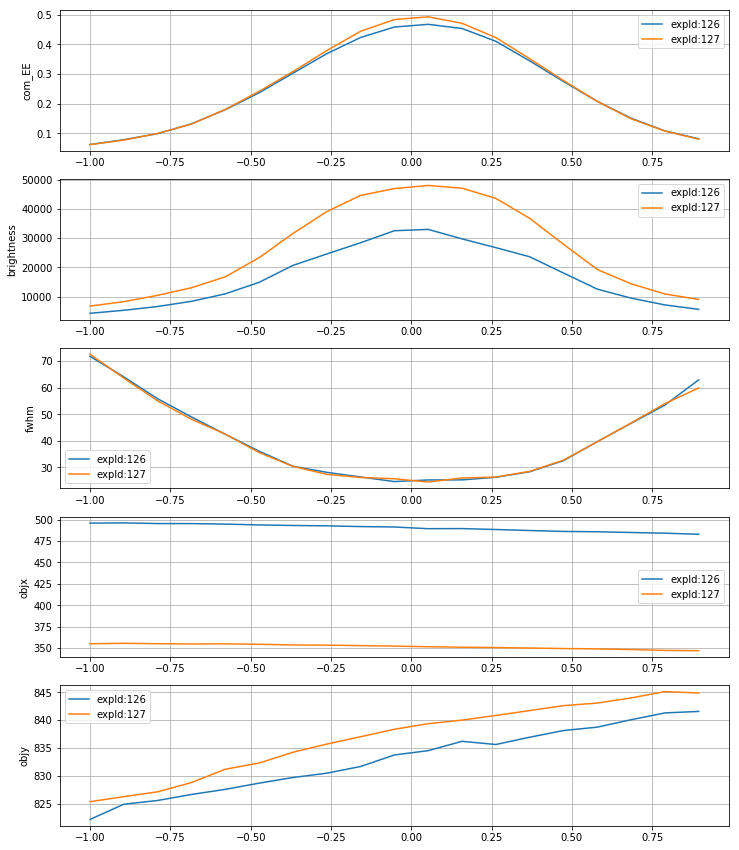

In [85]:
cols = ['com_EE', 'brightness', 'fwhm', 'objx', 'objy']
fig = plt.figure(figsize=(12, 15))

ax = [fig.add_subplot(int('%d11'%len(cols)))]

for i in range(1, len(cols)):
    ax.append(fig.add_subplot(int('%d1%d'%(len(cols), i+1)), sharex=ax[0]))

for experimentId, raw_df in cube.groupby('experimentId'):
    df = raw_df[lneg:lpos]
    for i, col in enumerate(cols):
        ax[i].plot(df.fca_x, df[col], label='expId:%d'%experimentId)
        ax[i].set_ylabel(col)
                 
for i, axi in enumerate(ax):
    axi.legend()
    axi.grid()


In [86]:
kwargs = dict(subplots= True,
              sharex= True,
              grid= True,
              figsize= (12, 8),
              marker='o')

In [87]:
select = cube.loc[cube['experimentId'] == 126]

/software/conda/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


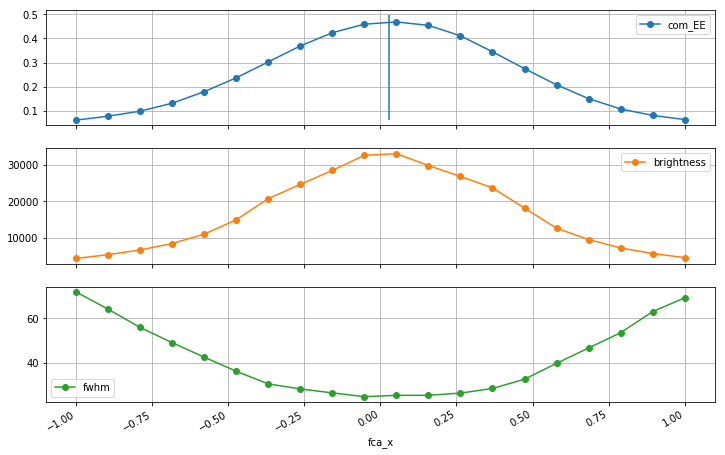

In [88]:
ax = select.plot(x='fca_x', y=[crit, 'brightness', 'fwhm'], **kwargs)
ax1 = ax[0]
ax1.vlines(color=ax1.get_lines()[-1].get_color(), **fit_EE.vline)